# UP for Astrobee

In [84]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import time

import sys, os
sys.path.append('../..')
from models.astrobee import Model
import utils

from scipy.spatial import ConvexHull

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Model + True Dynamics + Problem + Nominal Trajectory

In [85]:
# model + initial state
model = Model()
model.reset()
s13     = np.sqrt(1./3.)
x_init  = np.array([ 9.2,0.0,5.0,  1e-4,1e-4,1e-4,  s13,0.,s13,s13,     0,0,0])  + 1e-5

[astrobee::__init__] Initializing freeflyer Model 
                             (linear, uncertain mass and inertia).
[astrobee::reset] resetting mass, J, and deltas.
[astrobee::reset] resetting mass, J, and deltas.


In [86]:
# nominal traj example
T = 20
X_nom = np.load('data/Xtraj.npy')[:,:(T+1)] #np.save('data/Xtraj', Xtraj)
U_nom = np.load('data/Utraj.npy')[:,:T] #np.save('data/Utraj', Utraj)
X_nom.shape

(13, 21)

In [87]:
U_nom[0,:] = - 0.1*U_nom[0,:]

# Propagate Uncertainty

In [88]:
N_MC = 200

## (randUP)

In [89]:
start = time.time()
Xs_randUP, Us_randUP = model.simulate_batch(x_init, X_nom, U_nom,
                                              N_MC = N_MC, 
                                              B_resample = True)
print('elapsed time = ',time.time()-start)

elapsed time =  0.00513005256652832


## (robUP!)

In [90]:
T

20

In [91]:
Xs_robUP.shape

(100, 13, 21)

In [92]:
vec_Xs_robUP = []
volumes_robUP= []
n_adv        = 5
time_tot     = 0
idx_vol      = [0,1]

Xs_robUP, Us_robUP = Xs_randUP, Us_randUP
for i in range(n_adv):
    print('i =',i)
    start = time.time()
    # (robUP!)
    ms, Js, ws = model.adv_sample_params(Xs_robUP, Us_robUP)
    Xs_robUP, Us_robUP = model.simulate_batch(x_init, X_nom, U_nom,
                                 N_MC = N_MC, B_resample=False)
    time_tot = time.time()-start
    vec_Xs_robUP.append(Xs_robUP)
    # compute volume
    vols = np.zeros(T+1)
    for k in range(1,T+1):
        vols[k] = ConvexHull(Xs_robUP[:,idx_vol,k]).volume
time_tot = time_tot / n_adv

i = 0
i = 1
i = 2
i = 3
i = 4


## Plot results

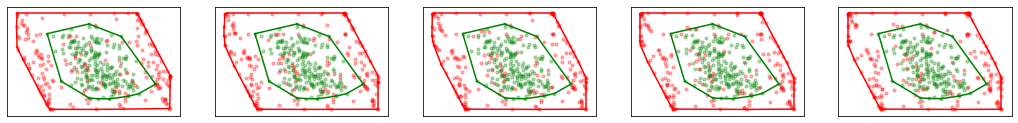

In [93]:
from utils.viz import plot_pts_2d, plot_trajs_2d
k = 6
idx = [0,1]

plt.figure(figsize=[18,2])
for i in range(n_adv):
    plt.subplot(1,n_adv,i+1)
    
    plot_pts_2d(Xs_randUP[:,:,k], idx=idx, color='g', alpha=0.3, markerwidth=10)
    hull = ConvexHull(Xs_randUP[:,idx,k])
    for simplex in hull.simplices:
        plt.plot(Xs_randUP[simplex,idx[0],k], Xs_randUP[simplex,idx[1],k], 'g-')
    
    Xs_robUP = vec_Xs_robUP[i]
    plot_pts_2d(Xs_robUP[:,:,k], idx=idx, color='r', alpha=0.3, markerwidth=10)
    hull = ConvexHull(Xs_robUP[:,idx,k])
    for simplex in hull.simplices:
        plt.plot(Xs_robUP[simplex,idx[0],k], Xs_robUP[simplex,idx[1],k], 'r-')
        
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

0 1
1 2
2 5


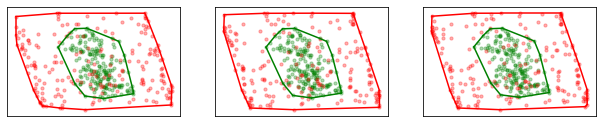

In [94]:
from utils.viz import plot_pts_2d, plot_trajs_2d
k = 12
idx = [0,1]

n_adv_vec = [1,2,5]

plt.figure(figsize=[18,2])
for i, n_adv_i in enumerate(n_adv_vec):
    print(i,n_adv_i)
    plt.subplot(1,n_adv,i+1)
    
    plot_pts_2d(Xs_randUP[:,:,k], idx=idx, color='g', alpha=0.3, markerwidth=10)
    hull = ConvexHull(Xs_randUP[:,idx,k])
    for simplex in hull.simplices:
        plt.plot(Xs_randUP[simplex,idx[0],k], Xs_randUP[simplex,idx[1],k], 'g-')
    
    Xs_robUP = vec_Xs_robUP[i]
    plot_pts_2d(Xs_robUP[:,:,k], idx=idx, color='r', alpha=0.3, markerwidth=10)
    hull = ConvexHull(Xs_robUP[:,idx,k])
    for simplex in hull.simplices:
        plt.plot(Xs_robUP[simplex,idx[0],k], Xs_robUP[simplex,idx[1],k], 'r-')
        
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

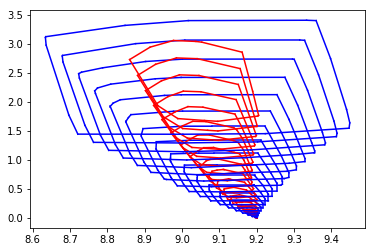

In [95]:
idx = [0,1]

# idx = [7,8]

for t in range(1,T):
    hull = ConvexHull(Xs_randUP[:,idx,t])
    for simplex in hull.simplices:
        plt.plot(Xs_randUP[simplex,idx[0],t], Xs_randUP[simplex,idx[1],t], 'r-')
        
    hull = ConvexHull(Xs_robUP[:,idx,t])
    for simplex in hull.simplices:
        plt.plot(Xs_robUP[simplex,idx[0],t], Xs_robUP[simplex,idx[1],t], 'b-')